# Chapter 1 - Outliers Analysis

## 1.1. Summary:

The data in the 'orders_and_shipments' table have shown some noticeable results. The outcome showed that the 'Shipment Days - Real' column (which is the resulting column of substracting the 'Shipment_Date' column from the 'Order_Date' column) contained values that were classified either as:

- 'Outlier: Extremely large values.
- 'Normal': Positive Non-extreme values.
- 'Data Entry Error': Values that are not logic or are incongruent with the context. 

The reason for this classification is that these values from the 'Shipment Days - Real' column were too far from the average or were negative values, the latter scenario suggests the data might have bee incorrectly entered in the table.

For this analysis, we have established that every value of 'Shipment Days' below zero (0) corresponds to a Data Entry Error (DEE), and the values that were greater than 3 times the mean of the positive 'Shipment Days' were classified as the Outliers. Looking at the Fig. 1, it is possible to assume that the outliers decreased and the data entry errors increased from 2015 to 2017.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ord_ships = pd.read_excel('orders_and_shipments_dimensions.xlsx',sheet_name='orders_and_shipments')
ord_ships.head()

Order ID    Order Item ID  Order_Date  ...  Gross Sales    Discount %   Profit 
0       3535             8793 2015-02-21  ...           400          0.25      200
1       4133            10320 2015-03-02  ...           400          0.09      200
2       7396            18517 2015-04-18  ...           400          0.06      200
3      11026            27608 2015-06-10  ...           400          0.15      200
4      11026            27609 2015-06-10  ...           400          0.13      200

[5 rows x 14 columns]

In [3]:
ord_ships.dtypes

Order ID                                int64
 Order Item ID                          int64
Order_Date                     datetime64[ns]
Order_Time                             object
Order Quantity                          int64
Product_ID                             object
Customer_ID                            object
Warehouse_ID                           object
Shipment_Date                  datetime64[ns]
Shipment Mode                          object
 Shipment Days - Scheduled              int64
 Gross Sales                            int64
 Discount %                            object
 Profit                                 int64
dtype: object

In [4]:
ord_ships['Shipment Days - Real'] = (ord_ships['Shipment_Date'] - ord_ships['Order_Date']).dt.days
ord_ships.head()

Order ID    Order Item ID   ...  Profit  Shipment Days - Real
0       3535             8793  ...      200                    6
1       4133            10320  ...      200                    4
2       7396            18517  ...      200                    2
3      11026            27608  ...      200                    2
4      11026            27609  ...      200                    2

[5 rows x 15 columns]

In [5]:
def count_negative(values):
    n_neg = 0
    for v in values:
        if v < 0:
            n_neg = n_neg+1
    return n_neg

In [6]:
len_SDR_neg = len(ord_ships['Shipment Days - Real'])
SDR_neg = count_negative(ord_ships['Shipment Days - Real'])
print(len_SDR_neg, SDR_neg)

30871 2735


In [7]:
ord_ships['SDR_Positive'] = ord_ships['Shipment Days - Real'].apply(lambda x: max(0,x))
ord_ships.head()

Order ID    Order Item ID   ... Shipment Days - Real SDR_Positive
0       3535             8793  ...                    6            6
1       4133            10320  ...                    4            4
2       7396            18517  ...                    2            2
3      11026            27608  ...                    2            2
4      11026            27609  ...                    2            2

[5 rows x 16 columns]

In [8]:
ord_ships['SDR_zscore'] = (ord_ships['SDR_Positive']-np.average(ord_ships['Shipment Days - Real'][ord_ships['Shipment Days - Real']>0]))/np.std(ord_ships['SDR_Positive'][ord_ships['Shipment Days - Real']>0],ddof=0)
ord_ships.head()

Order ID    Order Item ID   ... SDR_Positive SDR_zscore
0       3535             8793  ...            6  -0.201059
1       4133            10320  ...            4  -0.221852
2       7396            18517  ...            2  -0.242645
3      11026            27608  ...            2  -0.242645
4      11026            27609  ...            2  -0.242645

[5 rows x 17 columns]

In [9]:
def ev_outlier(row):
    if row['Shipment Days - Real'] < 0:
        return 'DEE'
    elif abs(row['SDR_zscore']) > 3:
        return 'Outlier'
    else:
        return 'Normal'

In [10]:
ord_ships['SDR_Outlier'] = ord_ships.apply(ev_outlier,axis=1)
ord_ships.head()

Order ID    Order Item ID  Order_Date  ... SDR_Positive  SDR_zscore SDR_Outlier
0       3535             8793 2015-02-21  ...            6   -0.201059      Normal
1       4133            10320 2015-03-02  ...            4   -0.221852      Normal
2       7396            18517 2015-04-18  ...            2   -0.242645      Normal
3      11026            27608 2015-06-10  ...            2   -0.242645      Normal
4      11026            27609 2015-06-10  ...            2   -0.242645      Normal

[5 rows x 18 columns]

In [11]:
ord_ships['SDR_Outlier'].value_counts()

Normal     27409
DEE         2735
Outlier      727
Name: SDR_Outlier, dtype: int64

In [12]:
ord_ships['O_Year'] = pd.DatetimeIndex(ord_ships['Order_Date']).year
ord_ships['O_Month'] = pd.DatetimeIndex(ord_ships['Order_Date']).month
ord_ships['O_Month'] = ord_ships['O_Month'].apply(lambda x: f'{x:02d}')
ord_ships['O_Week'] = ord_ships['Order_Date'].dt.isocalendar().week
ord_ships['O_Week'] = ord_ships['O_Week'].apply(lambda x: f'{x:02d}')
ord_ships['O_YM'] = ord_ships['O_Year'].astype(str).str.cat(ord_ships['O_Month'].astype(str), sep="-")
ord_ships['O_YW'] = ord_ships['O_Year'].astype(str).str.cat(ord_ships['O_Week'].astype(str),sep="-")
ord_ships.head()

Order ID    Order Item ID  Order_Date  ... O_Week     O_YM     O_YW
0       3535             8793 2015-02-21  ...     08  2015-02  2015-08
1       4133            10320 2015-03-02  ...     10  2015-03  2015-10
2       7396            18517 2015-04-18  ...     16  2015-04  2015-16
3      11026            27608 2015-06-10  ...     24  2015-06  2015-24
4      11026            27609 2015-06-10  ...     24  2015-06  2015-24

[5 rows x 23 columns]

In [13]:
mean_sd = np.round(np.mean(ord_ships['SDR_Positive']),2)
std_sd = np.round(np.std(ord_ships['SDR_Positive'],ddof=0),2)
print(f"The mean of the positive values is: {mean_sd} and the standard deviation is {std_sd}")

The mean of the positive values is: 22.37 and the standard deviation is 90.74


The mean of the positive values is: 22.37 days and the standard deviation is 90.74 days.

In [14]:
Zscore = 3
Xvalue = mean_sd+Zscore*std_sd
print(f"If an atypical value is defined as any value which Z score is greater than 3. Given the previous mean of {mean_sd} days and standard deviation of {std_sd} days,then the result is that any shipment that took more than {Xvalue} to be delivered is considered an Outlier.")

If an atypical value is defined as any value which Z score is greater than 3. Given the previous mean of 22.37 days and standard deviation of 90.74 days,then the result is that any shipment that took more than 294.59 to be delivered is considered an Outlier.


If an atypical value is defined as any value which Z score is greater than 3. Given the previous mean of 22.37 days and standard deviation of 90.74 days,then the result is that any shipment that took more than 294.59 days to be delivered is considered an Outlier.

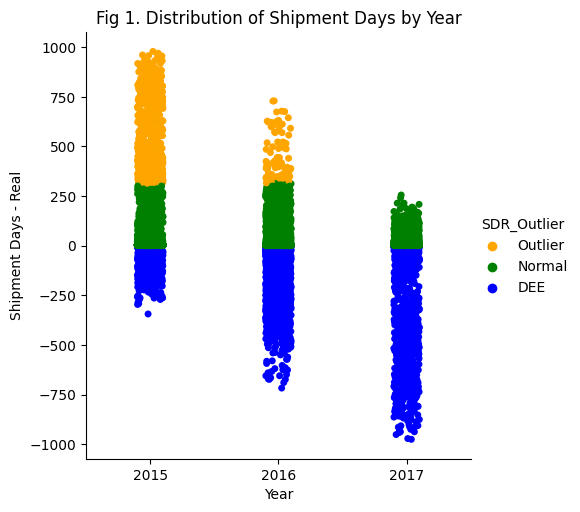

In [15]:
import seaborn as sns
custom_palette = {'Outlier': 'orange', 'Normal': 'green', 'DEE': 'blue'}
custom_hue_order = ['Outlier','Normal', 'DEE']
sns.catplot(ord_ships, x="O_Year", y="Shipment Days - Real", palette=custom_palette, hue="SDR_Outlier", hue_order=custom_hue_order, kind='strip')
plt.xlabel("Year")
plt.ylabel("Shipment Days - Real")
plt.title("Fig 1. Distribution of Shipment Days by Year")
plt.show()

In [16]:
ord_ships_oly = ord_ships[['SDR_Outlier','O_Year']].groupby(['O_Year','SDR_Outlier']).size().reset_index(name='Count')
ord_ships_oly

O_Year SDR_Outlier  Count
0    2015         DEE    524
1    2015      Normal   9473
2    2015     Outlier    624
3    2016         DEE   1063
4    2016      Normal  10048
5    2016     Outlier    103
6    2017         DEE   1148
7    2017      Normal   7888

In [17]:
os_olyp = ord_ships_oly.pivot(index='O_Year', columns='SDR_Outlier', values='Count').fillna(0)
os_olyp

SDR_Outlier     DEE   Normal  Outlier
O_Year                               
2015          524.0   9473.0    624.0
2016         1063.0  10048.0    103.0
2017         1148.0   7888.0      0.0

In [18]:
os_olyp['Total'] = os_olyp.sum(axis=1)
os_olyp

SDR_Outlier     DEE   Normal  Outlier    Total
O_Year                                        
2015          524.0   9473.0    624.0  10621.0
2016         1063.0  10048.0    103.0  11214.0
2017         1148.0   7888.0      0.0   9036.0

In [19]:
os_olyp['DEE %'] = np.round((os_olyp['DEE']/os_olyp['Total'])*100,2)
os_olyp

SDR_Outlier     DEE   Normal  Outlier    Total  DEE %
O_Year                                               
2015          524.0   9473.0    624.0  10621.0   4.93
2016         1063.0  10048.0    103.0  11214.0   9.48
2017         1148.0   7888.0      0.0   9036.0  12.70

In [20]:
os_olyp['Outlier %'] = np.round((os_olyp['Outlier']/os_olyp['Total'])*100,2)
os_olyp

SDR_Outlier     DEE   Normal  Outlier    Total  DEE %  Outlier %
O_Year                                                          
2015          524.0   9473.0    624.0  10621.0   4.93       5.88
2016         1063.0  10048.0    103.0  11214.0   9.48       0.92
2017         1148.0   7888.0      0.0   9036.0  12.70       0.00

In [21]:
os_olyp['Total %'] = os_olyp[['DEE %', 'Outlier %']].sum(axis=1)
os_olyp

SDR_Outlier     DEE   Normal  Outlier    Total  DEE %  Outlier %  Total %
O_Year                                                                   
2015          524.0   9473.0    624.0  10621.0   4.93       5.88    10.81
2016         1063.0  10048.0    103.0  11214.0   9.48       0.92    10.40
2017         1148.0   7888.0      0.0   9036.0  12.70       0.00    12.70

## 1.2. Errors and Outliers by Time Period:

When analyzing the data points by different time periods, the results show a proportional increase in DEE and a decrease in Outliers from 2015 to 2017. The same pattern can be observed when analyzing the data by different time periods:

* Year (Fig 2).
* Month (Fig 3).
* Week of the Year (Fig 4).
* Year-Month (YM) combination (Fig 5).
* Year-Week (YW) combination (Fig 6).

There could be several causes in the increase of negative values. This phenomenom could be due to human error when entering the data (if the procedure is manual), or it could be an error in the parameters that map the data to the database (in case this information is generated through an automated procedure).

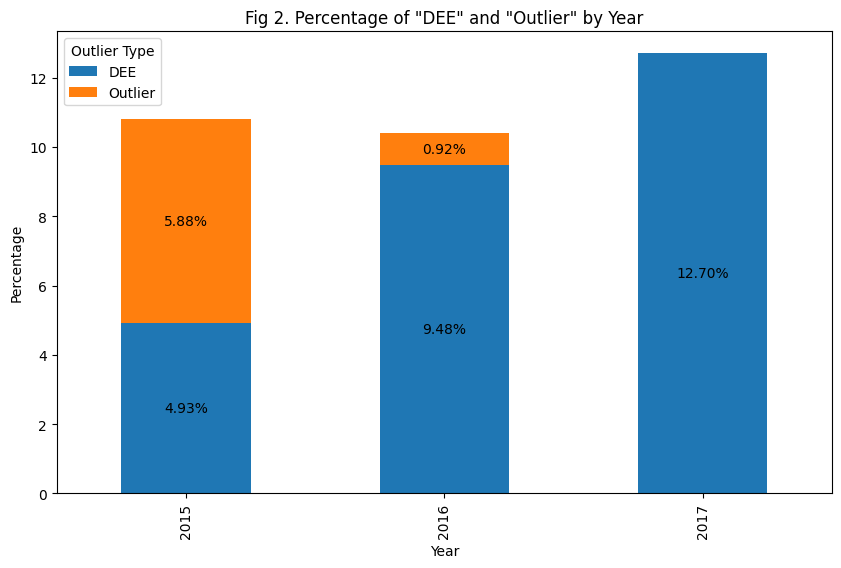

In [22]:
ax = os_olyp[['DEE %','Outlier %']].plot(kind='bar',stacked=True,figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Percentage')
plt.title('Fig 2. Percentage of "DEE" and "Outlier" by Year')
plt.legend(title='Outlier Type', loc='upper left', labels=['DEE','Outlier'])

for p in ax.patches:
    if p.get_height() == 0:
        continue
    width, height = p.get_width(), p.get_height()
    x,y = p.get_xy()
    ax.annotate(f'{height:.2f}%', (x+width/2, y+height/2), ha='center', va='center')
    
plt.show()

In [23]:
def group_by_period_type(data,col1,col2):
    gbpt = data[[col1,col2]].groupby([col1,col2]).size().reset_index(name='Count')
    return gbpt

In [24]:
ord_ships_olm = group_by_period_type(ord_ships,'O_Month','SDR_Outlier')
ord_ships_olm

O_Month SDR_Outlier  Count
0       01         DEE    181
1       01      Normal   2490
2       01     Outlier    126
3       02         DEE    199
4       02      Normal   2323
5       02     Outlier     73
6       03         DEE    191
7       03      Normal   2420
8       03     Outlier     84
9       04         DEE    210
10      04      Normal   2440
11      04     Outlier     67
12      05         DEE    214
13      05      Normal   2404
14      05     Outlier     58
15      06         DEE    214
16      06      Normal   2328
17      06     Outlier     68
18      07         DEE    244
19      07      Normal   2481
20      07     Outlier     47
21      08         DEE    244
22      08      Normal   2485
23      08     Outlier     54
24      09         DEE    253
25      09      Normal   2384
26      09     Outlier     40
27      10         DEE    261
28      10      Normal   1978
29      10     Outlier     37
30      11         DEE    252
31      11      Normal   1872
32      11     Outlier     40
33      12         DEE    272
34      12      Normal   1804
35      12     Outlier     33

In [25]:
def pivot_period_type(data,index,columns,values):
    ppt = data.pivot(index=index, columns=columns, values=values).fillna(0)
    return ppt

In [26]:
os_olmp = pivot_period_type(ord_ships_olm,'O_Month','SDR_Outlier','Count')
os_olmp

SDR_Outlier  DEE  Normal  Outlier
O_Month                          
01           181    2490      126
02           199    2323       73
03           191    2420       84
04           210    2440       67
05           214    2404       58
06           214    2328       68
07           244    2481       47
08           244    2485       54
09           253    2384       40
10           261    1978       37
11           252    1872       40
12           272    1804       33

In [27]:
def total_col(data):
    total = data.sum(axis=1)
    return total

In [28]:
os_olmp['Total'] = total_col(os_olmp)
os_olmp

SDR_Outlier  DEE  Normal  Outlier  Total
O_Month                                 
01           181    2490      126   2797
02           199    2323       73   2595
03           191    2420       84   2695
04           210    2440       67   2717
05           214    2404       58   2676
06           214    2328       68   2610
07           244    2481       47   2772
08           244    2485       54   2783
09           253    2384       40   2677
10           261    1978       37   2276
11           252    1872       40   2164
12           272    1804       33   2109

In [29]:
def percent_out(data,col1,col2):
    percent = (data[col1]/data[col2])*100
    return percent

In [30]:
os_olmp['DEE %'] = np.round(percent_out(os_olmp,'DEE','Total'),2)
os_olmp

SDR_Outlier  DEE  Normal  Outlier  Total  DEE %
O_Month                                        
01           181    2490      126   2797   6.47
02           199    2323       73   2595   7.67
03           191    2420       84   2695   7.09
04           210    2440       67   2717   7.73
05           214    2404       58   2676   8.00
06           214    2328       68   2610   8.20
07           244    2481       47   2772   8.80
08           244    2485       54   2783   8.77
09           253    2384       40   2677   9.45
10           261    1978       37   2276  11.47
11           252    1872       40   2164  11.65
12           272    1804       33   2109  12.90

In [31]:
os_olmp['Outlier %'] = np.round(percent_out(os_olmp,'Outlier','Total'),2)
os_olmp

SDR_Outlier  DEE  Normal  Outlier  Total  DEE %  Outlier %
O_Month                                                   
01           181    2490      126   2797   6.47       4.50
02           199    2323       73   2595   7.67       2.81
03           191    2420       84   2695   7.09       3.12
04           210    2440       67   2717   7.73       2.47
05           214    2404       58   2676   8.00       2.17
06           214    2328       68   2610   8.20       2.61
07           244    2481       47   2772   8.80       1.70
08           244    2485       54   2783   8.77       1.94
09           253    2384       40   2677   9.45       1.49
10           261    1978       37   2276  11.47       1.63
11           252    1872       40   2164  11.65       1.85
12           272    1804       33   2109  12.90       1.56

In [32]:
def sum_col(data,col1,col2):
    col = data[[col1,col2]].sum(axis=1)
    return col

In [33]:
os_olmp['Total %'] = sum_col(os_olmp,'DEE %','Outlier %')
os_olmp

SDR_Outlier  DEE  Normal  Outlier  Total  DEE %  Outlier %  Total %
O_Month                                                            
01           181    2490      126   2797   6.47       4.50    10.97
02           199    2323       73   2595   7.67       2.81    10.48
03           191    2420       84   2695   7.09       3.12    10.21
04           210    2440       67   2717   7.73       2.47    10.20
05           214    2404       58   2676   8.00       2.17    10.17
06           214    2328       68   2610   8.20       2.61    10.81
07           244    2481       47   2772   8.80       1.70    10.50
08           244    2485       54   2783   8.77       1.94    10.71
09           253    2384       40   2677   9.45       1.49    10.94
10           261    1978       37   2276  11.47       1.63    13.10
11           252    1872       40   2164  11.65       1.85    13.50
12           272    1804       33   2109  12.90       1.56    14.46

In [34]:
def custom_bar_chart(data,col1,col2,col3,category,sort=False,fig='Fig 1.'):
    
    if sort==True:
        data = data.sort_values(col3, ascending=False)
    
    ax = data[[col1,col2]].plot(kind='bar',stacked=True,figsize=(10,6))
    plt.xlabel(f'{category}')
    plt.ylabel('Percentage')
    plt.title(f'{fig} Percentage of "DEE" and "Outlier" by {category}')
    plt.legend(title='Outlier Type', loc='upper left', labels=['DEE','Outlier'])
    
    if len(data[col1]) > 53:
        xtick_labels = data.index[0::4]
        plt.xticks(range(0,len(data),4), xtick_labels)
        plt.show()
    elif len(data[col1]) > 12:
        plt.show()
    else:
        for p in ax.patches:
            if p.get_height() == 0:
                continue
            width, height = p.get_width(), p.get_height()
            x,y = p.get_xy()
            ax.annotate(f'{height:.2f}%', (x+width/2, y+height/2), ha='center', va='center')

        plt.show()

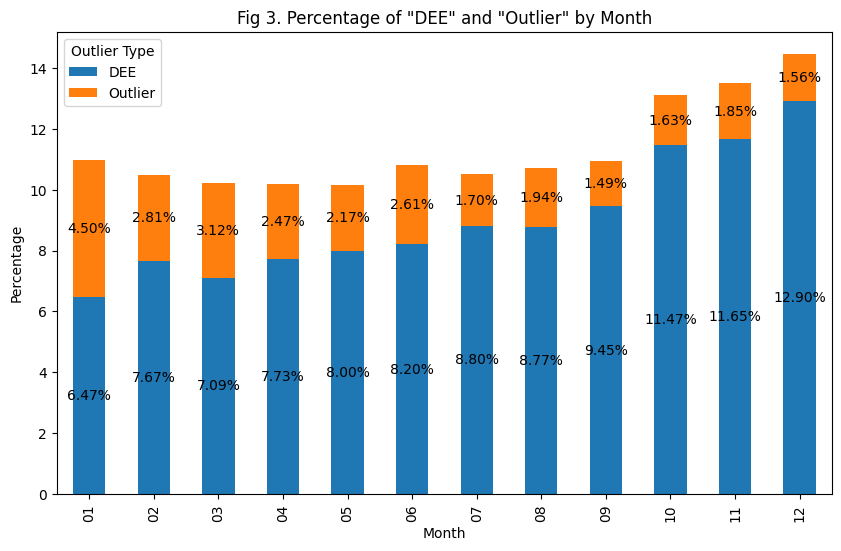

In [35]:
custom_bar_chart(os_olmp,'DEE %','Outlier %','Total %','Month',False,'Fig 3.')

In [36]:
ord_ships_olw = group_by_period_type(ord_ships,'O_Week','SDR_Outlier')
os_olwp = pivot_period_type(ord_ships_olw,'O_Week','SDR_Outlier','Count')
os_olwp['Total'] = total_col(os_olwp)
os_olwp['DEE %'] = np.round(percent_out(os_olwp,'DEE','Total'),2)
os_olwp['Outlier %'] = np.round(percent_out(os_olwp,'Outlier','Total'),2)
os_olwp['Total %'] = sum_col(os_olwp,'DEE %','Outlier %')
os_olwp


SDR_Outlier  DEE  Normal  Outlier  Total  DEE %  Outlier %  Total %
O_Week                                                             
01            36     511       30    577   6.24       5.20    11.44
02            39     525       28    592   6.59       4.73    11.32
03            44     512       21    577   7.63       3.64    11.27
04            51     638       24    713   7.15       3.37    10.52
05            29     565       30    624   4.65       4.81     9.46
06            42     505       18    565   7.43       3.19    10.62
07            46     529       16    591   7.78       2.71    10.49
08            73     685       20    778   9.38       2.57    11.95
09            43     502       13    558   7.71       2.33    10.04
10            40     582       26    648   6.17       4.01    10.18
11            38     542       10    590   6.44       1.69     8.13
12            41     503       17    561   7.31       3.03    10.34
13            56     638       21    715   7.83       2.94    10.77
14            39     532       15    586   6.66       2.56     9.22
15            63     575       14    652   9.66       2.15    11.81
16            45     535       15    595   7.56       2.52    10.08
17            48     614       19    681   7.05       2.79     9.84
18            40     537       14    591   6.77       2.37     9.14
19            36     511       11    558   6.45       1.97     8.42
20            73     584       14    671  10.88       2.09    12.97
21            45     592       20    657   6.85       3.04     9.89
22            45     471        8    524   8.59       1.53    10.12
23            36     400        7    443   8.13       1.58     9.71
24            47     569       20    636   7.39       3.14    10.53
25            76     663       27    766   9.92       3.52    13.44
26            42     627       15    684   6.14       2.19     8.33
27            41     429        5    475   8.63       1.05     9.68
28            67     464       11    542  12.36       2.03    14.39
29            82     836       19    937   8.75       2.03    10.78
30            41     550        9    600   6.83       1.50     8.33
31            40     413        7    460   8.70       1.52    10.22
32            47     492       12    551   8.53       2.18    10.71
33            67     725       20    812   8.25       2.46    10.71
34            59     609       11    679   8.69       1.62    10.31
35            56     516        7    579   9.67       1.21    10.88
36            53     458        6    517  10.25       1.16    11.41
37            67     657       14    738   9.08       1.90    10.98
38            68     718       12    798   8.52       1.50    10.02
39            59     407        3    469  12.58       0.64    13.22
40            42     287        6    335  12.54       1.79    14.33
41            56     437       10    503  11.13       1.99    13.12
42            70     631       15    716   9.78       2.09    11.87
43            54     410        7    471  11.46       1.49    12.95
44            62     311        3    376  16.49       0.80    17.29
45            84     412       18    514  16.34       3.50    19.84
46            38     483       15    536   7.09       2.80     9.89
47            62     546        5    613  10.11       0.82    10.93
48            51     334        2    387  13.18       0.52    13.70
49            40     352        5    397  10.08       1.26    11.34
50            56     448       16    520  10.77       3.08    13.85
51            71     586        7    664  10.69       1.05    11.74
52            78     312        3    393  19.85       0.76    20.61
53            11     139        6    156   7.05       3.85    10.90

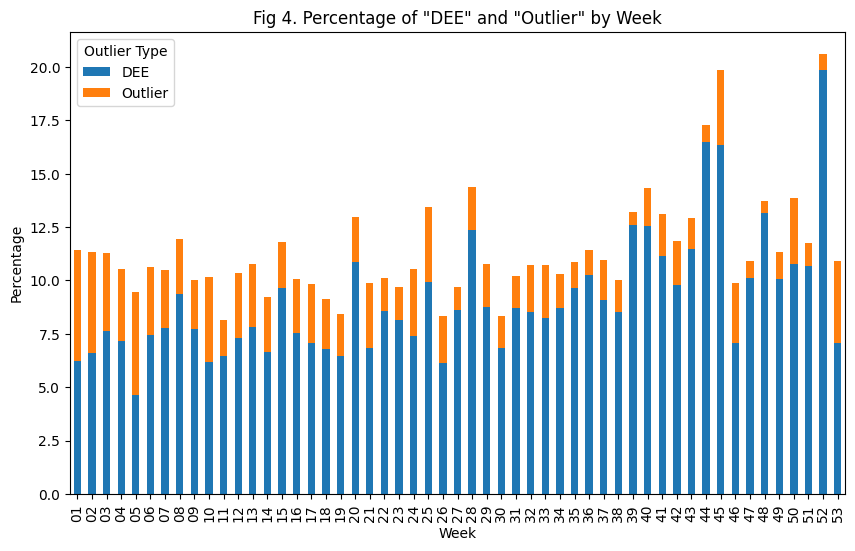

In [37]:
custom_bar_chart(os_olwp,'DEE %','Outlier %','Total %','Week',False,'Fig 4.')

In [38]:
def group_pivot_plot(data,col_period,col_type,category,fig, sort=False):
    data_gb = group_by_period_type(data,col_period,col_type)
    data_pivot = pivot_period_type(data_gb,col_period,col_type,'Count')
    data_pivot['Total'] = total_col(data_pivot)
    data_pivot['DEE %'] = np.round(percent_out(data_pivot,'DEE','Total'),2)
    data_pivot['Outlier %'] = np.round(percent_out(data_pivot,'Outlier','Total'),2)
    data_pivot['Total %'] = sum_col(data_pivot,'DEE %','Outlier %')
    bar_chart = custom_bar_chart(data_pivot,'DEE %','Outlier %','Total %',category,sort,fig)
    if sort==True:
        data_pivot = data_pivot.sort_values('Total %', ascending=False)
    return data_pivot

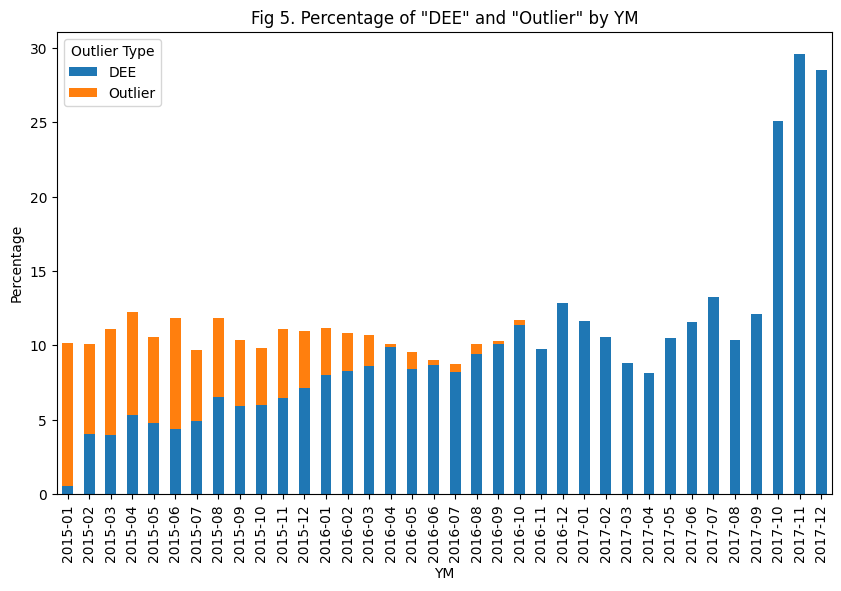

SDR_Outlier    DEE  Normal  Outlier   Total  DEE %  Outlier %  Total %
O_YM                                                                  
2015-01        5.0   882.0     95.0   982.0   0.51       9.67    10.18
2015-02       35.0   778.0     52.0   865.0   4.05       6.01    10.06
2015-03       37.0   826.0     66.0   929.0   3.98       7.10    11.08
2015-04       50.0   827.0     65.0   942.0   5.31       6.90    12.21
2015-05       39.0   730.0     47.0   816.0   4.78       5.76    10.54
2015-06       38.0   768.0     65.0   871.0   4.36       7.46    11.82
2015-07       43.0   796.0     42.0   881.0   4.88       4.77     9.65
2015-08       57.0   774.0     47.0   878.0   6.49       5.35    11.84
2015-09       50.0   760.0     38.0   848.0   5.90       4.48    10.38
2015-10       53.0   799.0     34.0   886.0   5.98       3.84     9.82
2015-11       55.0   759.0     40.0   854.0   6.44       4.68    11.12
2015-12       62.0   774.0     33.0   869.0   7.13       3.80    10.93
2016-01       78.0   865.0     31.0   974.0   8.01       3.18    11.19
2016-02       68.0   731.0     21.0   820.0   8.29       2.56    10.85
2016-03       75.0   777.0     18.0   870.0   8.62       2.07    10.69
2016-04       89.0   810.0      2.0   901.0   9.88       0.22    10.10
2016-05       81.0   873.0     11.0   965.0   8.39       1.14     9.53
2016-06       75.0   788.0      3.0   866.0   8.66       0.35     9.01
2016-07       81.0   898.0      5.0   984.0   8.23       0.51     8.74
2016-08       97.0   930.0      7.0  1034.0   9.38       0.68    10.06
2016-09       90.0   802.0      2.0   894.0  10.07       0.22    10.29
2016-10      117.0   907.0      3.0  1027.0  11.39       0.29    11.68
2016-11       94.0   868.0      0.0   962.0   9.77       0.00     9.77
2016-12      118.0   799.0      0.0   917.0  12.87       0.00    12.87
2017-01       98.0   743.0      0.0   841.0  11.65       0.00    11.65
2017-02       96.0   814.0      0.0   910.0  10.55       0.00    10.55
2017-03       79.0   817.0      0.0   896.0   8.82       0.00     8.82
2017-04       71.0   803.0      0.0   874.0   8.12       0.00     8.12
2017-05       94.0   801.0      0.0   895.0  10.50       0.00    10.50
2017-06      101.0   772.0      0.0   873.0  11.57       0.00    11.57
2017-07      120.0   787.0      0.0   907.0  13.23       0.00    13.23
2017-08       90.0   781.0      0.0   871.0  10.33       0.00    10.33
2017-09      113.0   822.0      0.0   935.0  12.09       0.00    12.09
2017-10       91.0   272.0      0.0   363.0  25.07       0.00    25.07
2017-11      103.0   245.0      0.0   348.0  29.60       0.00    29.60
2017-12       92.0   231.0      0.0   323.0  28.48       0.00    28.48

In [39]:
os_olmyp = group_pivot_plot(ord_ships,'O_YM','SDR_Outlier','YM','Fig 5.',False)
os_olmyp

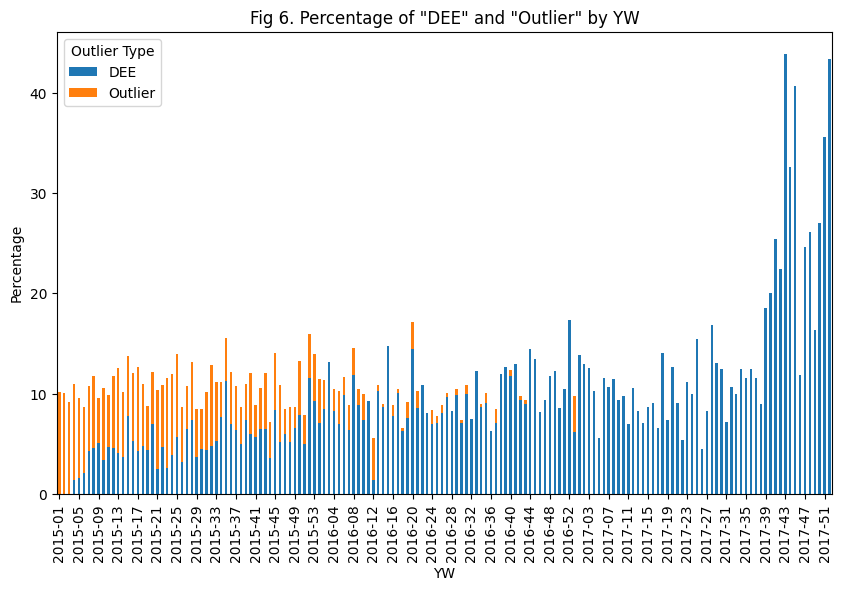

SDR_Outlier   DEE  Normal  Outlier  Total  DEE %  Outlier %  Total %
O_YW                                                                
2015-01       0.0   124.0     14.0  138.0   0.00      10.14    10.14
2015-02       0.0   187.0     21.0  208.0   0.00      10.10    10.10
2015-03       0.0   209.0     21.0  230.0   0.00       9.13     9.13
2015-04       3.0   187.0     20.0  210.0   1.43       9.52    10.95
2015-05       4.0   226.0     20.0  250.0   1.60       8.00     9.60
...           ...     ...      ...    ...    ...        ...      ...
2017-48      17.0    48.0      0.0   65.0  26.15       0.00    26.15
2017-49      18.0    92.0      0.0  110.0  16.36       0.00    16.36
2017-50      20.0    54.0      0.0   74.0  27.03       0.00    27.03
2017-51      21.0    38.0      0.0   59.0  35.59       0.00    35.59
2017-52      23.0    30.0      0.0   53.0  43.40       0.00    43.40

[158 rows x 7 columns]

In [40]:
os_olwyp = group_pivot_plot(ord_ships,'O_YW','SDR_Outlier','YW','Fig 6.',False)
os_olwyp

## 1.3. Errors and Outliers by Other Dimensions:

Additionally, we have plotted and analyzed the distribution of errors and outliers by different dimensions:

* Customer Market (Fig 7).
* Product Department (Fig 8).
* Warehouse Country (Fig 9).
* Shipment Mode (Fig 10).

The results indicates that these errors and outliers are present in all of those dimensions, data entry errors in a greater proportion than outliers.

In [41]:
customers = pd.read_excel("orders_and_shipments_dimensions.xlsx", sheet_name="customers")
customers.head()

Customer_ID  Customer_No  ...      Cust_Region Cust_Market
0    CUS00001        10001  ...   Western Europe      Europe
1    CUS00002        10001  ...  Central America       LATAM
2    CUS00003        10003  ...   Western Europe      Europe
3    CUS00004        10003  ...  Central America       LATAM
4    CUS00005        10007  ...   Western Europe      Europe

[5 rows x 11 columns]

In [42]:
ord_cust_merge = ord_ships.merge(customers[["Customer_ID","Cust_Market"]],on="Customer_ID",how="left")
ord_cust_merge

Order ID    Order Item ID  Order_Date  ...     O_YM     O_YW   Cust_Market
0           3535             8793 2015-02-21  ...  2015-02  2015-08         LATAM
1           4133            10320 2015-03-02  ...  2015-03  2015-10         LATAM
2           7396            18517 2015-04-18  ...  2015-04  2015-16         LATAM
3          11026            27608 2015-06-10  ...  2015-06  2015-24        Europe
4          11026            27609 2015-06-10  ...  2015-06  2015-24        Europe
...          ...              ...        ...  ...      ...      ...           ...
30866      73246           176561 2017-12-05  ...  2017-12  2017-49  Pacific Asia
30867       7908            19762 2015-04-26  ...  2015-04  2015-17         LATAM
30868      29326            73368 2016-03-04  ...  2016-03  2016-09  Pacific Asia
30869      63308           158284 2017-07-13  ...  2017-07  2017-28        Europe
30870      67951           169874 2017-09-18  ...  2017-09  2017-38        Europe

[30871 rows x 24 columns]

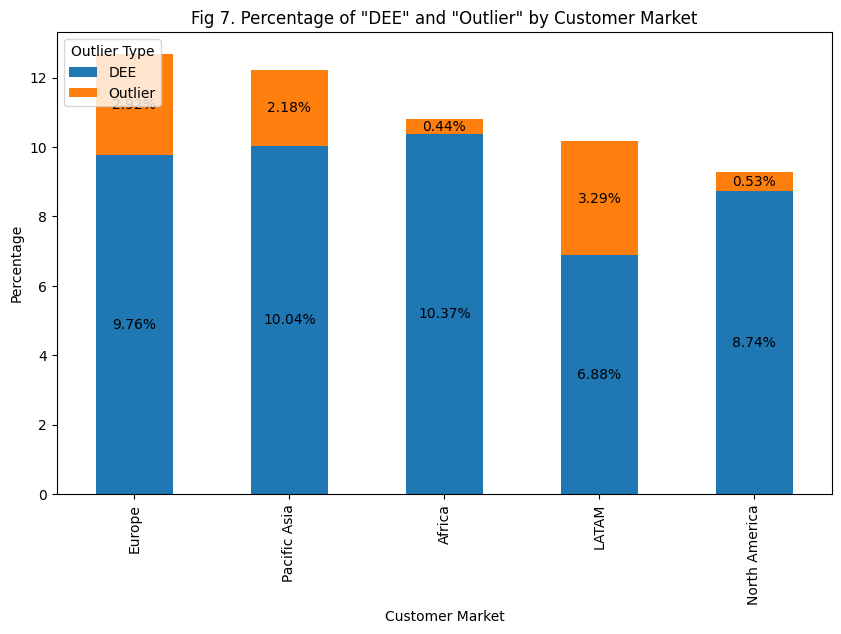

SDR_Outlier    DEE  Normal  Outlier  Total  DEE %  Outlier %  Total %
Cust_Market                                                          
Europe         842    7530      252   8624   9.76       2.92    12.68
Pacific Asia   655    5724      142   6521  10.04       2.18    12.22
Africa         212    1824        9   2045  10.37       0.44    10.81
LATAM          627    8191      300   9118   6.88       3.29    10.17
North America  399    4140       24   4563   8.74       0.53     9.27

In [43]:
oc_olmp = group_pivot_plot(ord_cust_merge,'Cust_Market','SDR_Outlier','Customer Market','Fig 7.',True)
oc_olmp

In [44]:
prod_cat_dep = pd.read_excel("orders_and_shipments_dimensions.xlsx", sheet_name="products_categories_departments")
prod_cat_dep.head()

Product_ID  ... Product Department
0  PROD00001  ...           Fan Shop
1  PROD00002  ...           Fan Shop
2  PROD00003  ...           Fan Shop
3  PROD00004  ...           Fan Shop
4  PROD00005  ...           Outdoors

[5 rows x 4 columns]

In [45]:
ord_pdep_merge = ord_ships.merge(prod_cat_dep[["Product_ID","Product Department"]], on="Product_ID", how="left")
ord_pdep_merge

Order ID    Order Item ID   ...     O_YW Product Department
0           3535             8793  ...  2015-08           Fan Shop
1           4133            10320  ...  2015-10           Fan Shop
2           7396            18517  ...  2015-16           Fan Shop
3          11026            27608  ...  2015-24           Fan Shop
4          11026            27609  ...  2015-24           Fan Shop
...          ...              ...  ...      ...                ...
30866      73246           176561  ...  2017-49           Fan Shop
30867       7908            19762  ...  2015-17           Fan Shop
30868      29326            73368  ...  2016-09           Fan Shop
30869      63308           158284  ...  2017-28           Fan Shop
30870      67951           169874  ...  2017-38           Fan Shop

[30871 rows x 24 columns]

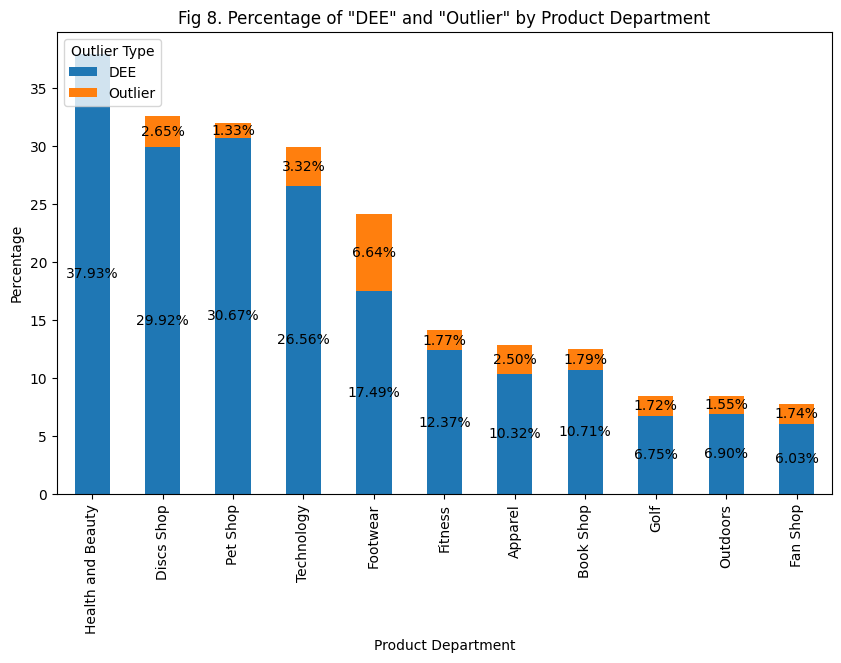

SDR_Outlier           DEE   Normal  Outlier    Total  DEE %  Outlier %  Total %
Product Department                                                             
Health and Beauty    11.0     18.0      0.0     29.0  37.93       0.00    37.93
Discs Shop           79.0    178.0      7.0    264.0  29.92       2.65    32.57
Pet Shop             23.0     51.0      1.0     75.0  30.67       1.33    32.00
Technology           64.0    169.0      8.0    241.0  26.56       3.32    29.88
Footwear            445.0   1930.0    169.0   2544.0  17.49       6.64    24.13
Fitness              49.0    340.0      7.0    396.0  12.37       1.77    14.14
Apparel             863.0   7289.0    209.0   8361.0  10.32       2.50    12.82
Book Shop             6.0     49.0      1.0     56.0  10.71       1.79    12.50
Golf                388.0   5259.0     99.0   5746.0   6.75       1.72     8.47
Outdoors            111.0   1473.0     25.0   1609.0   6.90       1.55     8.45
Fan Shop            696.0  10653.0    201.0  11550.0   6.03       1.74     7.77

In [46]:
od_oldp = group_pivot_plot(ord_pdep_merge,'Product Department','SDR_Outlier','Product Department','Fig 8.',True)
od_oldp

In [47]:
ware_coun = pd.read_excel("orders_and_shipments_dimensions.xlsx", sheet_name="warehouse")
ware_coun

Warehouse_ID         Warehouse_Name  ... Ware_Region    Ware_Market
0      WA00001   Warehouse-USA-Center  ...   US Center  North America
1      WA00002  Warehouse-Puerto Rico  ...   Caribbean          LATAM

[2 rows x 10 columns]

In [48]:
ord_wc_merge = ord_ships.merge(ware_coun[["Warehouse_ID","Ware_Country_Name_EN"]],on="Warehouse_ID",how="left")
ord_wc_merge

Order ID    Order Item ID   ...     O_YW Ware_Country_Name_EN
0           3535             8793  ...  2015-08          Puerto Rico
1           4133            10320  ...  2015-10          Puerto Rico
2           7396            18517  ...  2015-16          Puerto Rico
3          11026            27608  ...  2015-24          Puerto Rico
4          11026            27609  ...  2015-24          Puerto Rico
...          ...              ...  ...      ...                  ...
30866      73246           176561  ...  2017-49          Puerto Rico
30867       7908            19762  ...  2015-17          Puerto Rico
30868      29326            73368  ...  2016-09          Puerto Rico
30869      63308           158284  ...  2017-28          Puerto Rico
30870      67951           169874  ...  2017-38          Puerto Rico

[30871 rows x 24 columns]

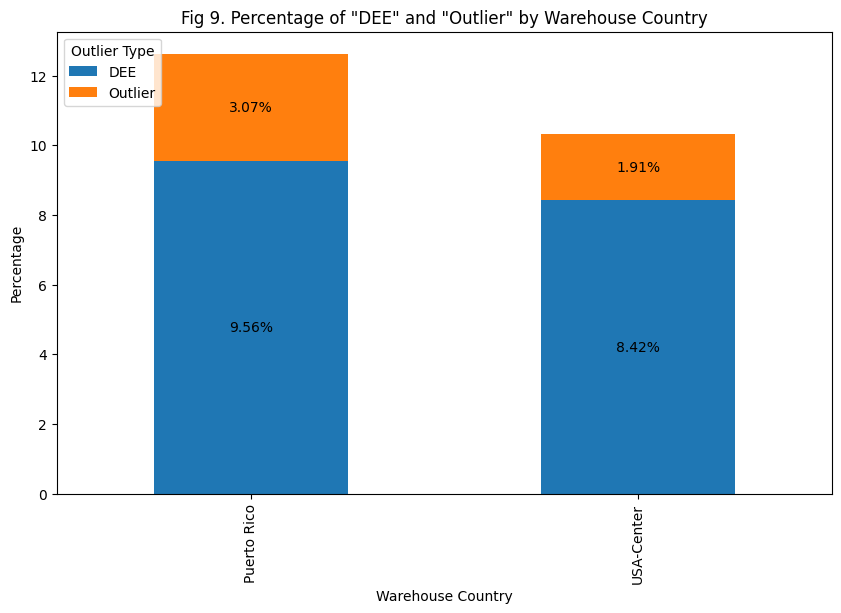

SDR_Outlier            DEE  Normal  Outlier  Total  DEE %  Outlier %  Total %
Ware_Country_Name_EN                                                         
Puerto Rico           1135   10374      365  11874   9.56       3.07    12.63
USA-Center            1600   17035      362  18997   8.42       1.91    10.33

In [49]:
ow_olwp = group_pivot_plot(ord_wc_merge,'Ware_Country_Name_EN','SDR_Outlier','Warehouse Country','Fig 9.',True)
ow_olwp

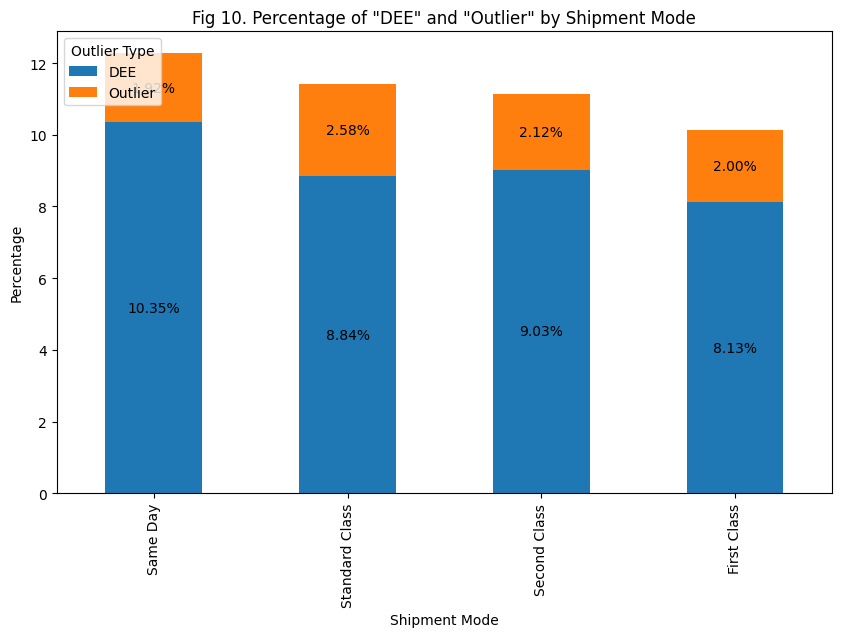

SDR_Outlier      DEE  Normal  Outlier  Total  DEE %  Outlier %  Total %
Shipment Mode                                                          
Same Day         205    1737       38   1980  10.35       1.92    12.27
Standard Class  1590   15940      464  17994   8.84       2.58    11.42
Second Class     545    5365      128   6038   9.03       2.12    11.15
First Class      395    4367       97   4859   8.13       2.00    10.13

In [50]:
osm_olsmp = group_pivot_plot(ord_ships,'Shipment Mode','SDR_Outlier','Shipment Mode','Fig 10.', True)
osm_olsmp